In [ ]:
#Thư viện
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
#Tách bộ data thành các class với tên bệnh riêng

In [14]:
import os
import shutil

# Đường dẫn thư mục
root_dir = r"D:\Machinelearning\Bai_tap_nhom\Train_data\Train"
target_dir = r"D:\Machinelearning\Bai_tap_nhom\Train_data\Or_traindata"

#Ánh xạ từ khóa viết tắt -> Tên lớp đầy đủ
class_mapping = {
    'cocci': 'Coccidiosis',
    'ncd': 'Newcastle',
    'salmo': 'Salmonella',
    'healthy': 'Healthy'
}

# Tạo thư mục để lưu
for folder in set(class_mapping.values()):
    os.makedirs(os.path.join(target_dir, folder), exist_ok=True)

print("Đang xử lý các tệp tin dính liền (ví dụ: pcrcocci, pcrncd)...")

count = 0
not_found = []

#quét và phân loại
for filename in os.listdir(root_dir):
    fn_lower = filename.lower()
    
    #Chỉ lấy file ảnh
    if not fn_lower.endswith(('.png', '.jpg', '.jpeg')):
        continue

    found = False
    for keyword, folder_name in class_mapping.items():
        if keyword in fn_lower:
            src_path = os.path.join(root_dir, filename)
            dst_path = os.path.join(target_dir, folder_name, filename)
            shutil.copy(src_path, dst_path)
            count += 1
            found = True
            break
            
    if not found:
        not_found.append(filename)

print(f"Xử lý xong! Đã sao chép {count} ảnh vào các thư mục bệnh.")
if not_found:
    print(f"Cảnh báo: Có {len(not_found)} file không nhận diện được lớp:")
    for f in not_found[:5]: 
        print(f" - {f}")

#thống kê số lượng sau khi gom
print("\nBảng thống kê số lượng ảnh:")
for folder in sorted(set(class_mapping.values())):
    num = len(os.listdir(os.path.join(target_dir, folder)))
    print(f" > {folder.ljust(15)}: {num} ảnh")

Đang xử lý các tệp tin dính liền (ví dụ: pcrcocci, pcrncd)...
Xử lý xong! Đã sao chép 8067 ảnh vào các thư mục bệnh.

Bảng thống kê số lượng ảnh:
 > Coccidiosis    : 2476 ảnh
 > Healthy        : 2404 ảnh
 > Newcastle      : 562 ảnh
 > Salmonella     : 2625 ảnh


In [15]:
# 2. Data
DATA_DIR = r"D:\Machinelearning\Bai_tap_nhom\Train_data\Or_traindata"
IMG_SIZE = (224, 224) #kích thước ảnh 224x224
BATCH_SIZE = 32 # Batch size là số lượng mẫu dữ liệu được đưa vào mô hình trong mỗi lần cập nhật trọng số (weight update) --> chia dữ liệu thành nhiều batch nhỏ.
VAL_SPLIT = 0.2 #20% cho tập validation
EPOCHS = 10

In [ ]:
# 3. Tiền xử lý & Tăng cường dữ liệu (Augmentation)
# ImageDataGenerator trong Keras dùng để chuẩn bị và biến đổi dữ liệu ảnh đầu vào trước khi đưa vào mô hình
# Chuẩn hóa dữ liệu (Normalization) → giúp mô hình học nhanh và ổn định hơn.
# Tăng cường dữ liệu (Data Augmentation) → tạo thêm biến thể mới của ảnh để giúp mô hình tổng quát hóa tốt hơn, tránh overfitting.
from tensorflow.keras.applications.efficientnet import preprocess_input
train_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input, # Chuẩn hóa chuẩn cho EfficientNet
    rotation_range=40,         # Xoay nhẹ ảnh trong khoảng ±20 độ --> Giúp mô hình chống lại sự lệch góc, học vật thể vẫn giống nhau dù xoay nhẹ
    width_shift_range=0.2,     # Dịch ngang lên đến 20% chiều rộng ảnh --> học được vị trí vật thể không cố định trong ảnh
    height_shift_range=0.2,    # Dịch dọc lên đến 20% chiều cao ảnh --> tăng khả năng nhận dạng bất chấp vật thể ở vị trí khác
    zoom_range=0.2,            # Phóng to/thu nhỏ ảnh trong khoảng ±20% 
    horizontal_flip=True,      # Lật ngang --> Hữu ích cho ảnh đối xứng
    fill_mode='nearest',    #lấp đầy những pixel bị thiếu khi dịch chuyển, xoay
    validation_split=VAL_SPLIT # Tách tập validation
)

# Tạo generator cho tập huấn luyện
train_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='training',
    class_mode='categorical'   
)

# Tạo generator cho tập validation
val_gen = train_datagen.flow_from_directory(
    DATA_DIR,
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    subset='validation',
    class_mode='categorical',
    shuffle=False
)

# Lấy tên các lớp
class_names = list(train_gen.class_indices.keys())
print("Các lớp:", class_names)
class_names = list(val_gen.class_indices.keys())


Found 6455 images belonging to 4 classes.
Found 1612 images belonging to 4 classes.
Các lớp: ['Coccidiosis', 'Healthy', 'Newcastle', 'Salmonella']


In [ ]:
#huấn luyện mô hình

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.optimizers import Adam
from sklearn.utils.class_weight import compute_class_weight

base_mode = EfficientNetB0(
    weights = 'imagenet',
    include_top = False,
    input_shape= (224, 224, 3)
)

#đóng băng
base_mode.trainable = False

#xây dựng mô hình
model = models.Sequential([
    base_mode,
    layers.GlobalAveragePooling2D(),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(len(class_names), activation='softmax')
])

#cấu hình huấn luyệnn
model.compile(
    optimizer = Adam(learning_rate = 0.001),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

# Lấy danh sách nhãn từ generator
train_labels = train_gen.classes
class_indices = train_gen.class_indices
labels = list(class_indices.values())

# Tính toán trọng số lớp tự động
weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

# Chuyển thành dictionary để đưa vào mô hình
class_weights_dict = dict(zip(np.unique(train_labels), weights))

print("Trọng số các lớp để cân bằng dữ liệu:")
for name, index in class_indices.items():
    print(f"- {name}: {class_weights_dict[index]:.2f}")

#huấn luyện lần một
history = model.fit(    
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    class_weight=class_weights_dict
)

# Mở đóng băng toàn bộ
base_mode.trainable = True

#đóng băng lại trừ 20 lớp cuối cùng
for layer in base_mode.layers[:-20]:
    layer.trainable = False

#fine-tuning
model.compile(
    optimizer = tf.keras.optimizers.Adam(1e-5),
    loss = 'categorical_crossentropy',
    metrics = ['accuracy']
)

#Huấn luyện lần hai
history = model.fit(
    train_gen,
    validation_data = val_gen,
    epochs = EPOCHS,
    class_weight=class_weights_dict
)


Trọng số các lớp để cân bằng dữ liệu:
- Coccidiosis: 0.81
- Healthy: 0.84
- Newcastle: 3.59
- Salmonella: 0.77
Epoch 1/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 221s 1s/step - accuracy: 0.7616 - loss: 0.6898 - val_accuracy: 0.8970 - val_loss: 0.3463
Epoch 2/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 156s 772ms/step - accuracy: 0.8655 - loss: 0.3985 - val_accuracy: 0.8654 - val_loss: 0.3446
Epoch 3/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 151s 746ms/step - accuracy: 0.8779 - loss: 0.3622 - val_accuracy: 0.8610 - val_loss: 0.3555
Epoch 4/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 138s 683ms/step - accuracy: 0.8877 - loss: 0.3271 - val_accuracy: 0.8592 - val_loss: 0.3688
Epoch 5/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 134s 662ms/step - accuracy: 0.8981 - loss: 0.2977 - val_accuracy: 0.8449 - val_loss: 0.4340
Epoch 6/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 133s 657ms/step - accuracy: 0.8968 - loss: 0.3075 - val_accuracy: 0.8567 - val_loss: 0.3752
Epoch 7/10
202/202 ━━━━━━━━━━━━━━━━━━━━ 141s 697ms/step - accuracy: 0.9070 - loss: 0.2819 - val_accu

51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 591ms/step - accuracy: 0.8567 - loss: 0.4049

 Độ chính xác trên tập validation: 0.8567


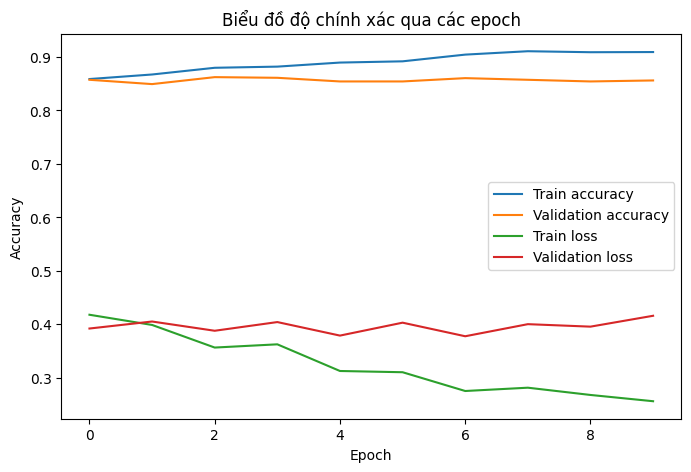

In [ ]:
#Đánh giá mô hình
test_loss, test_acc = model.evaluate(val_gen)
print(f"\n Độ chính xác trên tập validation: {test_acc:.4f}")

#Biểu đồ
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.plot(history.history['loss'], label='Train loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title('Biểu đồ độ chính xác qua các epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [21]:
#Lưu mô hình
model.save("EfficientB0_ChickenDisease.keras")

In [33]:
# Đọc lại mô hình
from tensorflow.keras.models import load_model
model = load_model("EfficientB0_ChickenDisease.keras")

# Kiểm tra lại cấu trúc
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 1280)           │         5,120 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 4)              │         5,124 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,777,105 (25.85 MB)

 Trainable params: 1,358,644 (5.18 MB)

 Non-trainable params: 2,701,171 (10.30 MB)

 Optimizer params: 2,717,290 (10.37 MB)

51/51 ━━━━━━━━━━━━━━━━━━━━ 30s 552ms/step


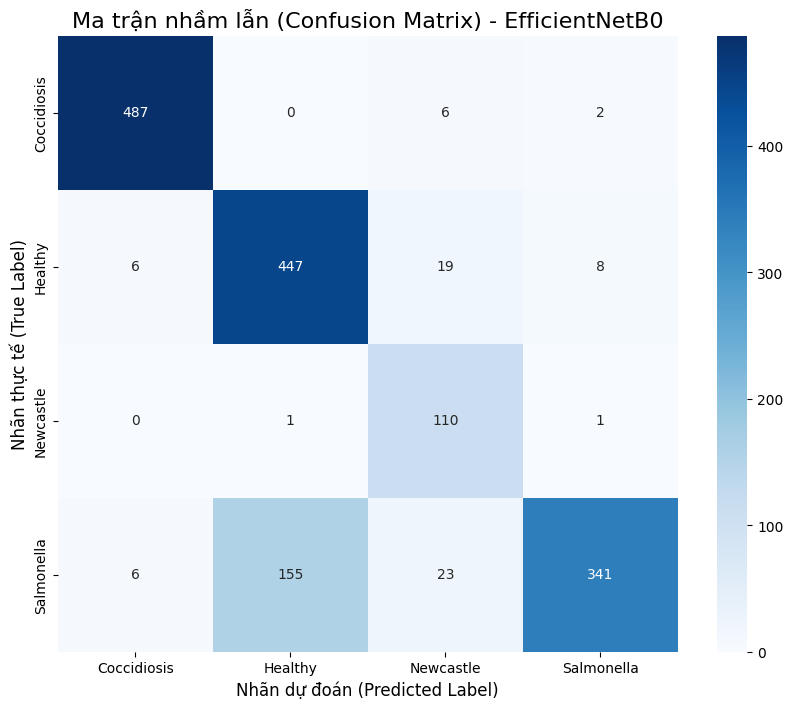

              precision    recall  f1-score   support

 Coccidiosis       0.98      0.98      0.98       495
     Healthy       0.74      0.93      0.83       480
   Newcastle       0.70      0.98      0.81       112
  Salmonella       0.97      0.65      0.78       525

    accuracy                           0.86      1612
   macro avg       0.85      0.89      0.85      1612
weighted avg       0.88      0.86      0.86      1612



In [34]:
#ma trận nhầm lẫn
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

#Lấy dự đoán từ mô hình trên tập validation
# Lưu ý: val_gen cần có shuffle=False để nhãn dự đoán khớp với nhãn thật
Y_pred_probs = model.predict(val_gen)
y_pred = np.argmax(Y_pred_probs, axis=1)
y_true = val_gen.classes

#Tạo ma trận nhầm lẫn
cm = confusion_matrix(y_true, y_pred)

#Vẽ biểu đồ với Seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=class_names, 
            yticklabels=class_names)

plt.title('Ma trận nhầm lẫn (Confusion Matrix) - EfficientNetB0', fontsize=16)
plt.ylabel('Nhãn thực tế (True Label)', fontsize=12)
plt.xlabel('Nhãn dự đoán (Predicted Label)', fontsize=12)
plt.show()

print(classification_report(y_true, y_pred, target_names=class_names))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


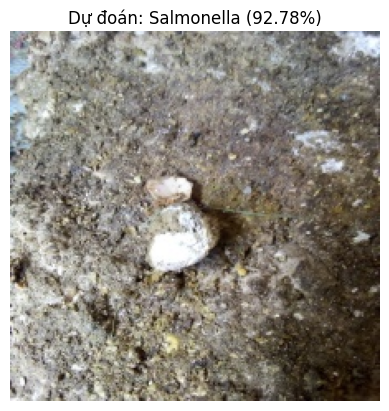

Ảnh được dự đoán là: Salmonella với độ tin cậy 92.78%


In [ ]:
#Dự đoán ảnh 
from tensorflow.keras.preprocessing import image

def predict_image(img_path):
    #Tải ảnh với kích thước (224, 224)
    img = image.load_img(img_path, target_size=IMG_SIZE)
    
    #Chuyển thành mảng và chuẩn bị batch
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x) 

    #Dự đoán
    pred = model.predict(x)
    #Lấy index của lớp có xác suất cao nhất
    idx = np.argmax(pred)
    predicted_class = class_names[idx]
    #Lấy phần trăm tự tin (Confidence)
    confidence = pred[0][idx] * 100

    #Hiển thị
    plt.imshow(image.load_img(img_path))
    plt.title(f"Dự đoán: {predicted_class} ({confidence:.2f}%)")
    plt.axis("off")
    plt.show()
    print(f"Ảnh được dự đoán là: {predicted_class} với độ tin cậy {confidence:.2f}%")

# Chạy thử
predict_image(r"D:\Machinelearning\Bai_tap_nhom\Train_data\Or_traindata\Salmonella\pcrsalmo.146.jpg")